## Fitting crltobsvsdaynumber.dat into a cosine expression

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

This is the crltobsvsdaynumber.dat from the rotationproject

In [2]:
# Load the .dat file into a pandas DataFrame
df = pd.read_csv('crltobsvsdaynumber.dat', delim_whitespace=True, header=None)
df.columns = ['Index', 'day', 'lat', 'lat_abs']
df.set_index('Index', inplace=True)
df

,day,lat,lat_abs
Index,,,
1,6328.5,-4.226103,4.226103
2,6329.5,-4.126043,4.126043
3,6330.5,-4.024859,4.024859
4,6331.5,-3.921519,3.921519
5,6332.5,-3.818179,3.818179
...,...,...,...
4700,11027.5,-7.204974,7.204974
4701,11028.5,-7.191523,7.191523
4702,11029.5,-7.175891,7.175891


In [3]:
df['lat_abs'].max()

7.239665

Plot Day Number and Spacecraft Latitude, and it shows a cosine function (as expected)

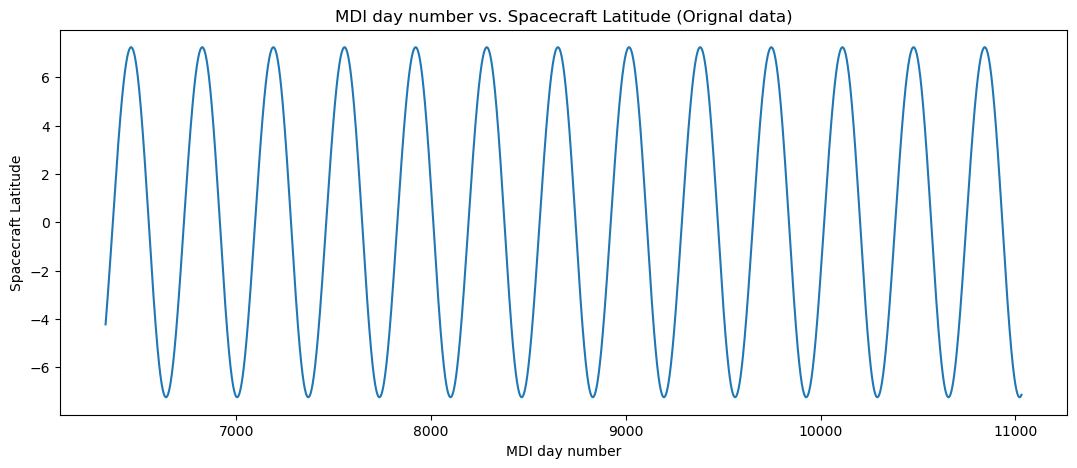

In [4]:
plt.figure(figsize=(13, 5))
plt.plot(df['day'], df['lat'])
plt.xlabel('MDI day number')
plt.ylabel('Spacecraft Latitude')
plt.title('MDI day number vs. Spacecraft Latitude (Orignal data)')
plt.show()

### Fit into cosine

In [5]:
# Define the cosine function
def cosine_func(x, A, B, C, D):
    return A * np.cos(B * x + C) + D

In [6]:
# Use 'day' as x and 'lat' as y
x = df['day'].values
y = df['lat'].values
x

array([ 6328.5,  6329.5,  6330.5, ..., 11029.5, 11030.5, 11031.5])

Manually find the period of the cosine wave by finding the distance between local minimums in 'day' (which is convinently a year): 

In [7]:
index1 = df[(df.day >= 6800) & (df.day <= 7200)].lat.idxmin()
index2 = df[(df.day >= 7201) & (df.day <= 7500)].lat.idxmin()
period = df['day'][index2] - df['day'][index1]
period   # Huh

365.0

In [8]:
# Manually define Initial guess parameters for a better output
A1 = (df['lat'].max() - df['lat'].min()) * 0.5   # 7.26?
B1 = 2*np.pi / period
C1 = 0
D1 = 0

In [9]:
# Initial guess for the parameters [A, B, C, D]  # GPT code
initial_guess = [A1, B1, C1, D1]

# Fit the data using curve_fit
params, covariance = curve_fit(cosine_func, x, y, p0=initial_guess)

# Extract the fitted parameters
A_res, B_res, C_res, D_res = params

## Result:

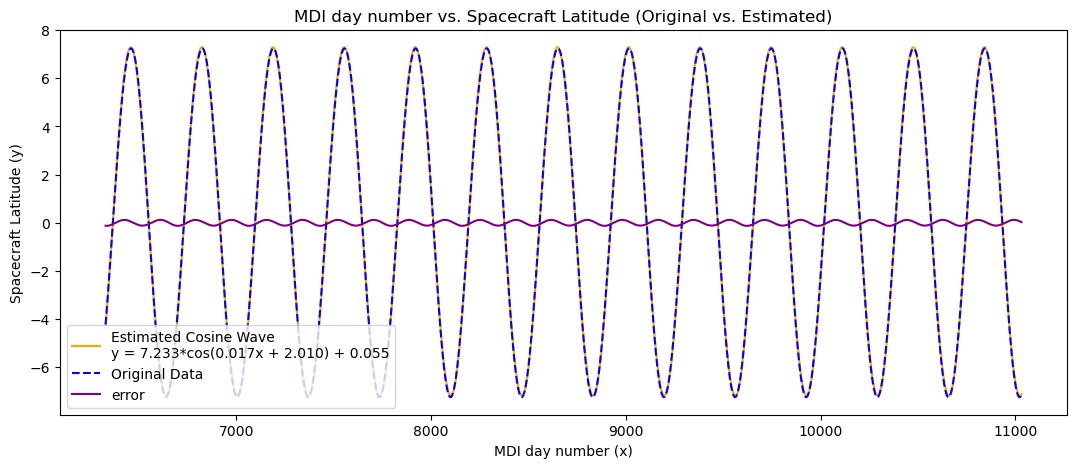

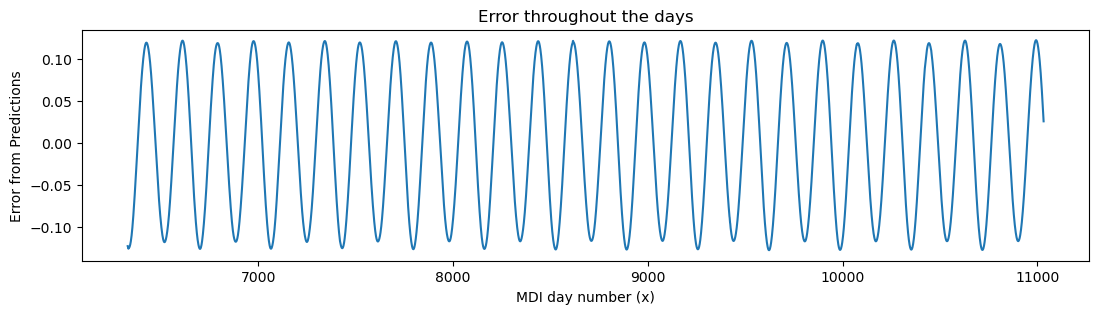

Amplitude (A): 7.232852366444651, 
Frequency-related (B): 0.0172018510257096  =>  Period: 365.26216264684786, 
Phase shift (C): 2.010061571540732, 
Vertical offset (D): 0.05485869581354516
The Cosine Function (rounded to the 5th decimal place): y = 7.23285*cos(0.01720x + 2.01006) + 0.05486

Test errors:

Mean Squared Error: 0.007346111369232224


,day,lat,lat_abs,lat_pred,test_error
Index,,,,,
1,6328.5,-4.226103,4.226103,-4.348596,-0.122493
2,6329.5,-4.126043,4.126043,-4.249246,-0.123203
3,6330.5,-4.024859,4.024859,-4.148623,-0.123764
4,6331.5,-3.921519,3.921519,-4.046756,-0.125237
5,6332.5,-3.818179,3.818179,-3.943676,-0.125497
...,...,...,...,...,...
4700,11027.5,-7.204974,7.204974,-7.162092,0.042882
4701,11028.5,-7.191523,7.191523,-7.152779,0.038744
4702,11029.5,-7.175891,7.175891,-7.141334,0.034557


In [10]:
def get_plot(df=df, A=A_res, B=B_res, C=C_res, D=D_res):
    # Test data:
    x_test = df['day']
    y_test = [cosine_func(i, A, B, C, D) for i in x_test]
    
    # Test error:
    err = []
    for i in range(len(x)):
        err.append(y_test[i] - y[i])
    
    plt.figure(figsize=(13, 5))
    # Test
    plt.plot(x_test, y_test, label=f'Estimated Cosine Wave \ny = {A:.3f}*cos({B:.3f}x + {C:.3f}) + {D:.3f}', color='orange')
    # Original
    plt.plot(x, y, label='Original Data', color = 'blue', linestyle='--')
    # Error
    plt.plot(x, err, label='error', color='purple')
    
    plt.xlabel('MDI day number (x)')
    plt.ylabel('Spacecraft Latitude (y)')
    plt.title('MDI day number vs. Spacecraft Latitude (Original vs. Estimated)')
    plt.legend(loc='lower left')
    plt.show()

    # Plot the error alone
    plt.figure(figsize=(13, 3))
    plt.plot(x, err)
    plt.title('Error throughout the days')
    plt.xlabel('MDI day number (x)')
    plt.ylabel('Error from Predictions')
    plt.show()
    
    print(f"Amplitude (A): {A}, \nFrequency-related (B): {B}  =>  Period: {2*np.pi /B}, \nPhase shift (C): {C}, \nVertical offset (D): {D}")
    print(f'The Cosine Function (rounded to the 5th decimal place): y = {A:.5f}*cos({B:.5f}x + {C:.5f}) + {D:.5f}')
    print('\nTest errors:')
    df1 = df.copy()
    df1['lat_pred'] = y_test
    df1['test_error'] = err
    # Find Mean Squared Error
    mse = mean_squared_error(y, y_test)
    print("\nMean Squared Error:", mse)
    return df1

get_plot()

### Trying the 2nd set of values

I also tried the parameters you mentioned in the email. I adjusted the amplitude to 7.26 (latitude variation for the earth) and orbital period to 365.25636 days (according to Google). I kept D (vertical offset) intact since that may imply the spacecraft is going at a slightly different orbit from earth's.

The resulting error / MSE is very close to what I had above (slightly worse but negligable). Thus, it confirms what you mentioned in the emails are right. I think the data above overfits. 

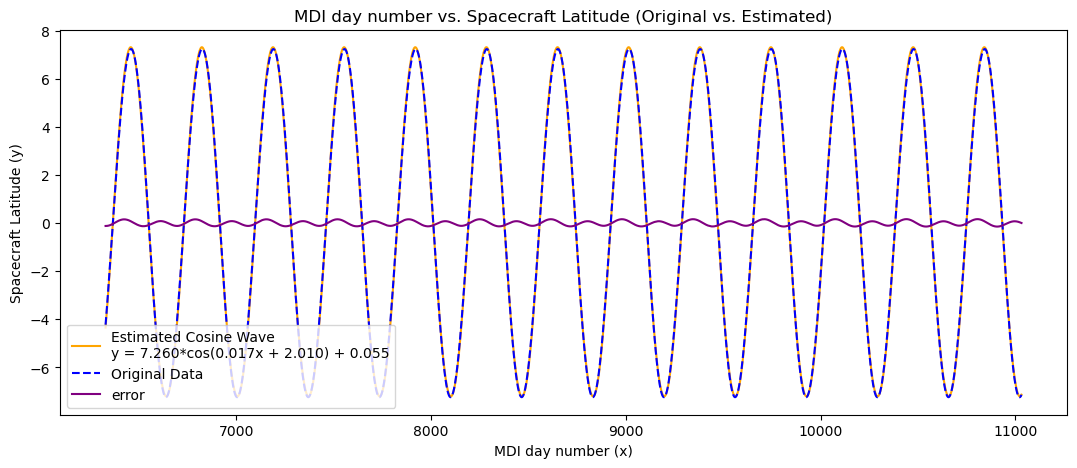

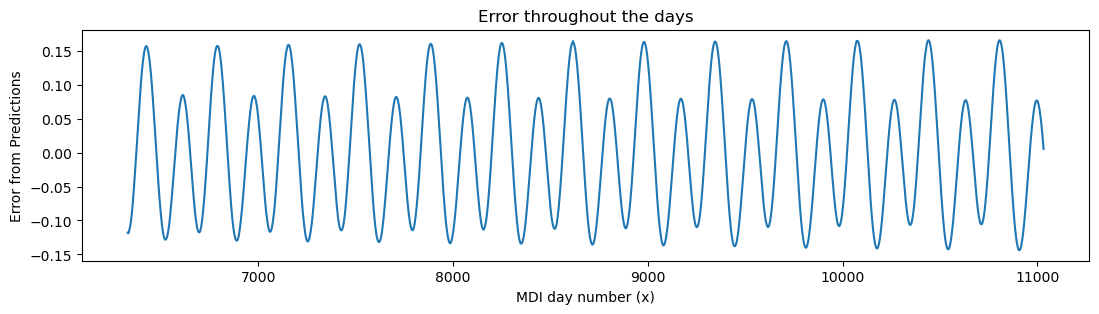

Amplitude (A): 7.26, 
Frequency-related (B): 0.017202423838958484  =>  Period: 365.25, 
Phase shift (C): 2.010061571540732, 
Vertical offset (D): 0.05485869581354516
The Cosine Function (rounded to the 5th decimal place): y = 7.26000*cos(0.01720x + 2.01006) + 0.05486

Test errors:

Mean Squared Error: 0.008386752548590018


,day,lat,lat_abs,lat_pred,test_error
Index,,,,,
1,6328.5,-4.226103,4.226103,-4.344216,-0.118113
2,6329.5,-4.126043,4.126043,-4.244218,-0.118175
3,6330.5,-4.024859,4.024859,-4.142949,-0.118090
4,6331.5,-3.921519,3.921519,-4.040437,-0.118918
5,6332.5,-3.818179,3.818179,-3.936713,-0.118534
...,...,...,...,...,...
4700,11027.5,-7.204974,7.204974,-7.185997,0.018977
4701,11028.5,-7.191523,7.191523,-7.175862,0.015661
4702,11029.5,-7.175891,7.175891,-7.163587,0.012304


In [11]:
# Use the metrics in the email

sidereal = 365.25   # mean Sidereal orbital period from Google
new_B = 2*np.pi / sidereal
get_plot(A=7.26, B=new_B)

### Trying the 3rd set of values

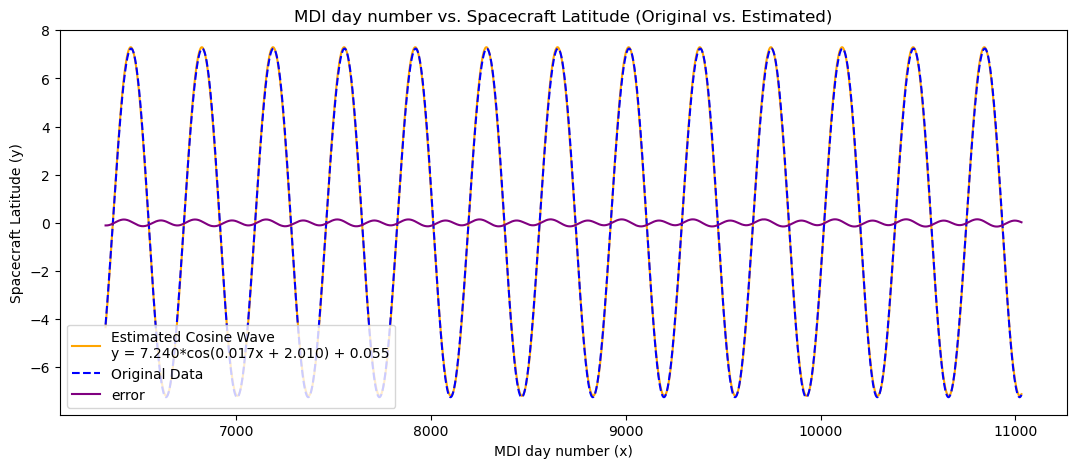

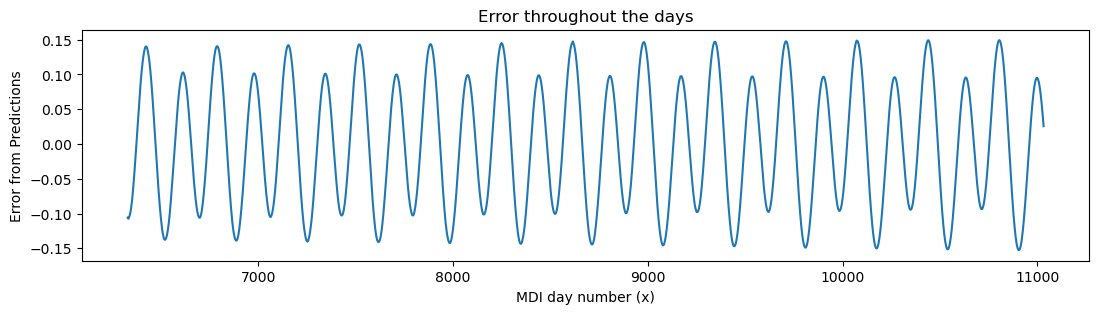

Amplitude (A): 7.2397, 
Frequency-related (B): 0.017202423838958484  =>  Period: 365.25, 
Phase shift (C): 2.010061571540732, 
Vertical offset (D): 0.05485869581354516
The Cosine Function (rounded to the 5th decimal place): y = 7.23970*cos(0.01720x + 2.01006) + 0.05486

Test errors:

Mean Squared Error: 0.008034969556019218


,day,lat,lat_abs,lat_pred,test_error
Index,,,,,
1,6328.5,-4.226103,4.226103,-4.331916,-0.105813
2,6329.5,-4.126043,4.126043,-4.232198,-0.106155
3,6330.5,-4.024859,4.024859,-4.131211,-0.106352
4,6331.5,-3.921519,3.921519,-4.028986,-0.107467
5,6332.5,-3.818179,3.818179,-3.925552,-0.107373
...,...,...,...,...,...
4700,11027.5,-7.204974,7.204974,-7.165750,0.039224
4701,11028.5,-7.191523,7.191523,-7.155644,0.035879
4702,11029.5,-7.175891,7.175891,-7.143404,0.032487


In [12]:
get_plot(A=7.2397, B=new_B)